In [2]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 81.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 88.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.6 MB/s eta 0:00:00


In [3]:
pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=83d4be2c1eccc21ceb6a31c5f736360f45acac133cda94c1ab3b7530df7a45e6
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [4]:
pip install backtrader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 13.8 MB/s eta 0:00:00


In [5]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.layers import Input, Flatten, BatchNormalization, concatenate
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from ta.volatility import BollingerBands
from ta.momentum import StochasticOscillator
import matplotlib.pyplot as plt
import backtrader as bt
import streamlit as st

In [6]:
# Загрузка данных из файла
def load_data_from_file(file_path):
  try:
    data = pd.read_csv(file_path)
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    return data
  except FileNotFoundError:
      print(f"Файл '{file_path}' не найден.")
      return None

# Загрузка данных из yaho finance
def load_data_from_yf(ticker, timeframe='1d'):
  df = yf.download(ticker, interval=timeframe)
  df = df.reset_index()
  if isinstance(df.columns, pd.MultiIndex):
      df.columns = df.columns.droplevel(level=1)
  df['Date'] = pd.to_datetime(df['Date'])
  df.set_index('Date', inplace=True)
  return df

In [7]:
# Индикатор RSI
def rsi(close_prices, n=14):
  delta = close_prices.diff().dropna()
  up = delta.clip(lower=0)
  down = -delta.clip(upper=0)
  rs = up.ewm(span=n, adjust=False).mean() / down.ewm(span=n, adjust=False).mean()
  return 100 - (100 / (1 + rs))

In [8]:
# Колонки для нормализации
columns_to_scale = ['Open', 'High', 'Low', 'Close', 'Volume', 'Mean', 'Value']
# Колонки, которые не нужно нормализовать
columns_not_to_scale = ['Predict', 'SMA', 'RSI', 'MACD', 'Signal_Line', 'ATR', 'bb_high', 'bb_low', 'so']

# Предобработка данных
def preprocess_data(data, window_size=30):
  # Добавление новых признаков
  data['Mean'] = (data['Open']+data['High']+data['Low']+data['Close']) / 4 # Средняя цена
  data['Value'] = data['Volume'] * data['Mean'] # Объём в деньгах
  data['SMA'] = data['Close'].rolling(window_size).mean()  # Скользящая средняя
  data['RSI'] = rsi(data['Close'], n=window_size)  # Индекс относительной силы
  data['MACD'] = data['Close'].ewm(span=12, adjust=False).mean() - data['Close'].ewm(span=26, adjust=False).mean()
  data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()
  data['ATR'] = data['High'] - data['Low']

  # Добавление Bollinger Bands
  indicator_bb = BollingerBands(close=data['Close'], window=20, window_dev=2)
  data['bb_high'] = indicator_bb.bollinger_hband()
  data['bb_low'] = indicator_bb.bollinger_lband()

  # Добавление Stochastic Oscillator
  indicator_so = StochasticOscillator(high=data['High'], low=data['Low'], close=data['Close'], window=14, smooth_window=3)
  data['so'] = indicator_so.stoch()

  # Формирование признака предсказания для стратегии, основанной на использовании GAP,
  # как отношения цены открытия завтра к цене закрытия сегодня
  data["Predict"] = data['Open'].shift(-1) / data["Close"]

  # Удаляем строки с NaN-значениями
  data.dropna(inplace=True)

  # Сохраняем реальные цены закрытия
  Close_prices = data['Close'].values

  # Нормализация данных только к выбранным колонкам
  scaler = MinMaxScaler(feature_range=(0, 1))
  #scaler = StandardScaler()
  #scaler = RobustScaler()
  scaled_data = scaler.fit_transform(data[columns_to_scale])

  # Преобразуем результат обратно в DataFrame
  scaled_df = pd.DataFrame(scaled_data, columns=columns_to_scale)

  # Добавляем колонки, которые не нужно было нормализовать
  scaled_df[columns_not_to_scale] = data[columns_not_to_scale].reset_index(drop=True)

  # Сохраняем колонку 'Predict' для целевой переменной
  y_data = scaled_df['Predict'].values

  # Удаление колонки 'Predict' и преобразование DataFrame в массив NumPy для удобства работы
  X_data = scaled_df.drop(columns=['Predict']).values

  # Создание временных окон
  X, y = [], []
  for i in range(window_size, len(scaled_df)):
      X.append(X_data[i - window_size:i, :]) # Все колонки, кроме 'Predict'
      y.append(y_data[i]) # Целевая переменная колонка 'Predict'
  X, y = np.array(X), np.array(y)

  # Разделение на обучающую и тестовую выборки
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

  # Разделение Close_prices в том же отношении, что и X, y
  # Используем индексы, полученные при разбиении X и y
  split_index = len(X_train)
  Close_train = Close_prices[window_size:split_index + window_size]
  Close_test = Close_prices[split_index + window_size:]

  return X_train, X_test, y_train, y_test, Close_train, Close_test, scaler

In [9]:
def create_ensemble_model(input_shape):
    input_layer = Input(shape=input_shape)

    # LSTM ветвь
    lstm_branch = LSTM(50, return_sequences=True)(input_layer)
    lstm_branch = Dropout(0.2)(lstm_branch)
    lstm_branch = LSTM(50, return_sequences=False)(lstm_branch)
    lstm_branch = Dropout(0.2)(lstm_branch)

    # GRU ветвь
    gru_branch = GRU(50, return_sequences=True)(input_layer)
    gru_branch = Dropout(0.2)(gru_branch)
    gru_branch = GRU(50, return_sequences=False)(gru_branch)
    gru_branch = Dropout(0.2)(gru_branch)

    # Объединение ветвей
    merged = concatenate([lstm_branch, gru_branch])

    # Полносвязные слои
    dense_layer = Dense(25, activation='relu')(merged)
    output_layer = Dense(1)(dense_layer)

    model = Model(inputs=input_layer, outputs=output_layer, name='ensemble_model')
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [10]:
def train_model(model, X_train, y_train, epochs=50, batch_size=32):
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=1)
  return history

In [11]:
def test_model(model, X_test, y_test):
    # Получаем прогнозы
    predictions = model.predict(X_test)
    return predictions, y_test

In [12]:
def calculate_metrics(predictions, y_test):
  # метрика: точность направления движения цены
  pred_sign = np.sign(predictions -1)
  test_sign = np.sign(y_test - 1)
  direction_accuracy = accuracy_score(test_sign, pred_sign)
  rmse = np.mean((predictions - y_test) ** 2) ** 0.5
  mae = np.mean(np.abs(predictions - y_test))
  average = y_test.mean()
  rmse2avg = rmse / average
  mae2avg = mae / average
  return direction_accuracy, rmse, mae, rmse2avg, mae2avg

In [13]:
# Загрузка данных
#file_path = 'stock_data.csv'  # Замените на путь к вашему файлу
#data = load_data_from_file(file_path)
data = load_data_from_yf("AAPL")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [14]:
# Предобработка данных
X_train, X_test, y_train, y_test, Close_train, Close_test, scaler = preprocess_data(data)

In [15]:
# Создание и обучение модели
model = create_ensemble_model((X_train.shape[1], X_train.shape[2]))
history = train_model(model, X_train, y_train, 10)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 55s 67ms/step - loss: 0.0325 - val_loss: 0.0114
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 63ms/step - loss: 0.0046 - val_loss: 0.0066
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 62ms/step - loss: 0.0032 - val_loss: 0.0066
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - loss: 0.0024 - val_loss: 0.0031
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step - loss: 0.0021 - val_loss: 0.0033
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - loss: 0.0013 - val_loss: 3.1883e-04
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 65ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - loss: 9.8382e-04 - val_loss: 5.4483e-04


In [16]:
# Тестирование модели
predictions, y_test = test_model(model, X_test, y_test)

# Расчет метрик
direction_accuracy, rmse, mae, rmse2avg, mae2avg  = calculate_metrics(predictions, y_test)
print(f"Точность направления движения цены: {direction_accuracy:.4f}")
print(f"Средняя абсолютная ошибка цены (MAE): {mae:.4f}")
print(f"Средняя квадратичная ошибка цены (RMSE): {rmse:.4f}")
print(f"Относительная средняя абсолютная ошибка цены (MAE): {mae2avg:.4f}")
print(f"Относительная средняя квадратичная ошибка цены (RMSE): {rmse2avg:.4f}")

70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
Точность направления движения цены: 0.4574
Средняя абсолютная ошибка цены (MAE): 0.0491
Средняя квадратичная ошибка цены (RMSE): 0.0594
Относительная средняя абсолютная ошибка цены (MAE): 0.0491
Относительная средняя квадратичная ошибка цены (RMSE): 0.0594


In [17]:
count_less_than_1 = np.sum(predictions < 1)
count_great_than_1 = np.sum(predictions > 1)
print(f"Количество элементов меньше 1: {count_less_than_1}")
print(f"Количество элементов больше 1: {count_great_than_1}")

Количество элементов меньше 1: 2086
Количество элементов больше 1: 131


In [18]:
# Сохранение метрик в файл
metrics = {
    'Модель': model.name,
    'Точность направления': direction_accuracy,
    'Средняя абсолютная ошибка': mae,
    'Средняя квадратичная ошибка': rmse,
    'Относительная средняя абсолютная ошибка': mae2avg,
    'Относительная средняя квадратичная ошибка': rmse2avg
}
metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv('metrics.csv', index=False)

In [19]:
# Создание дашборда с использованием Streamlit
def create_dashboard(data, predictions, y_test):
    st.title('Дашборд торговой стратегии')
    st.write("### График прогнозов и реальных цен")
    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label='Реальные цены')
    plt.plot(predictions, label='Прогнозы')
    plt.legend()
    st.pyplot(plt)

    st.write("### Метрики модели")
    metrics_df = pd.read_csv('metrics.csv')
    st.table(metrics_df)

2025-03-02 20:35:33.940 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-02 20:35:34.483 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-03-02 20:35:34.484 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-02 20:35:34.485 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-02 20:35:34.486 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-02 20:35:34.487 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-02 20:35:34.487 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-02 20:35:34.521 Thread 'MainThread': mi

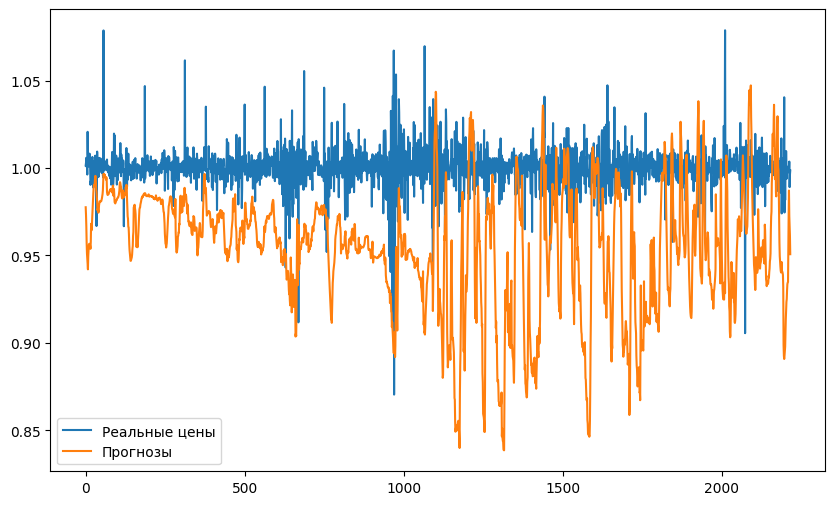

In [20]:
create_dashboard(data, predictions, y_test)

In [21]:
# Создание стратегии для backtrader
class SimulationStrategy(bt.Strategy):
    def __init__(self):
        self.prediction_index = 0  # Индекс для отслеживания текущего предсказания

    def next(self):
        if self.prediction_index < len(predictions):
            prediction = predictions[self.prediction_index]
            if prediction > 1:  # Если предсказание роста цены
                if not self.position:
                    self.buy()  # Открываем длинную позицию
            elif prediction < 1:  # Если предсказание падения цены
                if self.position:
                    self.sell()  # Закрываем позицию
            self.prediction_index += 1

In [27]:
# Создание экземпляра Cerebro
cerebro = bt.Cerebro()

# Добавление стратегии
cerebro.addstrategy(SimulationStrategy)

# Подготовка тестовых данных для backtrader
test_data = data.iloc[-len(X_test):]  # Выбираем тестовую часть данных
test_data = bt.feeds.PandasData(dataname=test_data)

# Добавление данных
cerebro.adddata(test_data)

# Добавление анализаторов
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="ta")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="sharpe")
cerebro.addanalyzer(bt.analyzers.DrawDown, _name="drawdown")
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='timereturn')

# Установка начального капитала
cerebro.broker.set_cash(10000.0)

# Запуск симуляции с анализаторами
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
analysis = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 10000.00
Final Portfolio Value: 9893.23


In [28]:
# Вывод дополнительных характеристик
def print_trade_analysis(analyzer):
    print("\n--- Trade Analysis ---")
    print(f"Total Trades: {analyzer.total.total}")
    print(f"Total Closed Trades: {analyzer.total.closed}")
    print(f"Total Open Trades: {analyzer.total.open}")
    print(f"Total Won: {analyzer.won.total}")
    print(f"Total Lost: {analyzer.lost.total}")
    print(f"Win Rate: {analyzer.won.total / analyzer.total.closed * 100:.2f}%")
    print(f"Average Win: {analyzer.won.pnl.average:.2f}")
    print(f"Average Loss: {analyzer.lost.pnl.average:.2f}")
    #print(f"Profit Factor: {analyzer.pnl.net.profit_factor:.2f}")

def print_sharpe_ratio(analyzer):
    print("\n--- Sharpe Ratio ---")
    print(f"Sharpe Ratio: {analyzer.get('sharperatio', 'N/A'):.2f}")

def print_drawdown(analyzer):
    print("\n--- Drawdown ---")
    print(f"Max Drawdown: {analyzer.max.drawdown:.2f}%")
    print(f"Max Money Drawdown: {analyzer.max.moneydown:.2f}")

# Вывод результатов анализа
print_trade_analysis(analysis[0].analyzers.ta.get_analysis())
print_sharpe_ratio(analysis[0].analyzers.sharpe.get_analysis())
print_drawdown(analysis[0].analyzers.drawdown.get_analysis())
capital_history = analysis[0].analyzers.timereturn.get_analysis().items()

# Визуализация результатов
cerebro.plot()


--- Trade Analysis ---
Total Trades: 25
Total Closed Trades: 25
Total Open Trades: 0
Total Won: 6
Total Lost: 19
Win Rate: 24.00%
Average Win: 3.40
Average Loss: -6.69

--- Sharpe Ratio ---
Sharpe Ratio: -8.64

--- Drawdown ---
Max Drawdown: 1.07%
Max Money Drawdown: 106.77


<IPython.core.display.Javascript object>

[[<Figure size 640x480 with 4 Axes>]]

In [29]:
# Добавление графика капитала в дашборд
def create_dashboard2(data, predictions, y_test, capital_history):
    st.title('Дашборд торговой стратегии')
    st.write("### График прогнозов и реальных цен")
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(y_test, label='Реальные цены')
    ax.plot(predictions, label='Прогнозы')
    ax.legend()
    st.pyplot(fig)

    st.write("### График изменения капитала")
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(capital_history, label='Капитал')
    ax.set_xlabel('Время')
    ax.set_ylabel('Капитал')
    ax.legend()
    st.pyplot(fig)

    st.write("### Метрики модели")
    metrics_df = pd.read_csv('metrics.csv')
    st.table(metrics_df)

In [30]:
create_dashboard2(data, predictions, y_test, capital_history)

2025-03-02 20:47:41.052 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-02 20:47:41.054 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-02 20:47:41.055 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-02 20:47:41.056 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-02 20:47:41.057 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-02 20:47:41.058 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-02 20:47:41.072 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-02 20:47:41.565 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

ВЫВОДЫ:
1. Модель плохо обучается по предсказыванию целевой величины и поэтому всегда предсказывает только повышение
2. Торговая стратегия не генерирует прибыль